## Table of Contents

- [Introduction](#introduction)

- [Links of Interest](#links)

- [Loading Data](#paths)
    - [Setting input and output paths](#paths)
    - [Dataset of text descriptions](#3) (Gene names and identifiers associated with phenotype descriptions and ontology term annotations)
    - [Dataset of groups or categories](#4) (Other sources of data, such as STRING and KEGG)
    - [Relating the datasets](#5) (Creating mappings between genes and their mentions in external datasets)
    - [Filtering the datasets](#6)
    
- [Loading Models](#part7)
    - [Why use embedding models?]()
    - [BERT and BioBERT]()
    - [Word2Vec and Doc2Vec]()
    
- [NLP Choices](#part8)
    - [Creating vocabularies](#part9) (Learning relevant words from ontology descriptions or text corpora)
    - [POS Tagging]() (Filtering words in descriptions to only include nouns or adjectives)
    - [Preprocessing descriptions]() (Choosing options specific to each type of vectorization or embedding method)
    - [Annotating descriptions]() (Running annotation tools and drawing from high-confidence curated annotations)
    
- [Building a Distance Matrix]()
    - [Defining a list of methods to use]()
    - [Running each method]()
    - [Adding additional information]()
    - [Something else]()
- [Analysis]()
    - [Comparing distributions of distance values between methods](#ks)
    - [Comparing the within-group distance values across gene groups and methods](#within)
    - [Comparing the AUC for predicting shared pathways, gene groups, or interactions between methods](#auc)
    - [Comparing querying for similar genes using distance matrices for each method](#y)
    - [Comparing the AUC for predicting the specific pathway or group of a gene](#mean)
    - [Generating a table of resulting metrics for each method](#output)
    

<a id="introduction"></a>
### Introduction: Text Mining Analysis of Phenotype Descriptions in Plants
The purpose of this notebook is to evaluate what can be learned from a natural language processing approach to analyzing free-text descriptions of phenotype descriptions of plants. The approach is to generate pairwise distances matrices between a set of plant phenotype descriptions across different species, sourced from academic papers and online model organism databases. These pairwise distance matrices can be constructed using any vectorization method that can be applied to natural language. In this notebook, we specifically evaluate the use of n-gram and bag-of-words techniques, word and document embedding using Word2Vec and Doc2Vec, context-dependent word-embeddings using BERT and BioBERT, and ontology term annotations with automated annotation tools such as NOBLE Coder.

Loading, manipulation, and filtering of the dataset of phenotype descriptions associated with genes across different plant species is largely handled through a Python package created for this purpose called OATS (Ontology Annotation and Text Similarity) which is available [here](https://github.com/irbraun/oats). Preprocessing of the descriptions, mapping the dataset to additional resources such as protein-protein interaction databases and biochemical pathway databases are handled in this notebook using that package as well. In the evaluation of each of these natural language processing approaches to analyzing this dataset of descriptions, we compare performance against a dataset generated through manual annotation of a similar dataset in Oellrich Walls et al. (2015) and against manual annotations with experimentally determined terms from the Gene Ontology (PO) and the Plant Ontology (PO).

<a id="links"></a>
### Links of Interest:
- Paper describing comparison of NLP and ontology annotation approaches to curation: [Braun, Lawrence-Dill (2019)](https://www.biorxiv.org/content/10.1101/689976v2.full)
- Paper describing results of manual phenotype description curation: [Oellrich, Walls et al. (2015](https://plantmethods.biomedcentral.com/articles/10.1186/s13007-015-0053-y)
- Plant databases with phenotype description text data available: [TAIR](https://www.arabidopsis.org/), [SGN](https://solgenomics.net/), [MaizeGDB](https://www.maizegdb.org/)
- Python package for working with phenotype descriptions: [OATS](https://github.com/irbraun/oats)
- Python package used for general NLP functions: [NLTK](https://www.nltk.org/)
- Python package used for working with biological ontologies: [Pronto](https://pronto.readthedocs.io/en/latest/)
- Python package for loading pretrained BERT models: [PyTorch Pretrained BERT](https://pypi.org/project/pytorch-pretrained-bert/)
- For BERT Models pretrained on PubMed and PMC: [BioBERT Paper](https://arxiv.org/abs/1901.08746), [BioBERT Models](https://github.com/naver/biobert-pretrained)

In [41]:
import datetime
import nltk
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import time
import math
import sys
import gensim
import os
import warnings
import torch
import itertools
import multiprocessing as mp
from collections import Counter, defaultdict
from inspect import signature
from scipy.stats import ks_2samp
from sklearn.metrics import precision_recall_curve, f1_score, auc
from sklearn.model_selection import train_test_split, KFold
from scipy import spatial, stats
from nltk.corpus import brown
from nltk.tokenize import word_tokenize
from sklearn.neighbors import KNeighborsClassifier
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
from gensim.parsing.preprocessing import strip_non_alphanum, stem_text, preprocess_string, remove_stopwords
from gensim.utils import simple_preprocess

sys.path.append("../../oats")
from oats.utils.utils import save_to_pickle, load_from_pickle, merge_list_dicts, flatten, to_hms
from oats.datasets.dataset import Dataset
from oats.datasets.groupings import Groupings
from oats.annotation.ontology import Ontology
from oats.datasets.string import String
from oats.datasets.edges import Edges
from oats.annotation.annotation import annotate_using_noble_coder
from oats.graphs import pairwise as pw
from oats.graphs.indexed import IndexedGraph
from oats.graphs.models import train_logistic_regression_model, apply_logistic_regression_model
from oats.graphs.models import train_random_forest_model, apply_random_forest_model
from oats.nlp.vocabulary import get_overrepresented_tokens, build_vocabulary_from_tokens
from oats.utils.utils import function_wrapper_with_duration
from oats.nlp.preprocess import concatenate_with_bar_delim

mpl.rcParams["figure.dpi"] = 400
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
nltk.download('punkt', quiet=True)
nltk.download('brown', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

<a id="paths"></a>
### Setting up the output table and input and output filepaths
This section defines some constants which are used for creating a uniquely named directory to contain all the outputs from running this instance of this notebook. The naming scheme is based on the time that the notebook is run. The other constants are used for specifying information in the output table about what the topic was for this notebook when it was run, such as looking at KEGG biochemical pathways or STRING protein-protein interaction data some other type of gene function grouping or hierarchy. These values are arbitrary and are just for keeping better notes about what the output of the notebook corresponds to. All the input and output file paths for loading datasets or models are also contained within this cell, so that if anything is moved the directories and file names should only have to be changed at this point and nowhere else further into the notebook. If additional files are added to the notebook cells they should be put here as well.

In [42]:
# The summarizing output dictionary has the shape TABLE[method][metric] --> value.
TOPIC = "Biochemical Pathways"
DATA = "Filtered"
TABLE = defaultdict(dict)
OUTPUT_DIR = os.path.join("../outputs",datetime.datetime.now().strftime('%m_%d_%Y_h%Hm%Ms%S'))
os.mkdir(OUTPUT_DIR)

In [43]:
dataset_filename = "../data/pickles/text_plus_annotations_dataset.pickle"        # The full dataset pickle.
groupings_filename = "../data/pickles/kegg_pathways.pickle"                      # The groupings pickle.
background_corpus_filename = "../data/corpus_related_files/untagged_text_corpora/background.txt"       # Text file with background content.
phenotypes_corpus_filename = "../data/corpus_related_files/untagged_text_corpora/phenotypes_small.txt" # Text file with specific content.
doc2vec_pubmed_filename = "../gensim/pubmed_dbow/doc2vec_2.bin"                  # File holding saved Doc2Vec model.
doc2vec_wikipedia_filename = "../gensim/enwiki_dbow/doc2vec.bin"                 # File holding saved Doc2Vec model.
word2vec_model_filename = "../gensim/wiki_sg/word2vec.bin"                       # File holding saved Word2Vec model.
ontology_filename = "../ontologies/mo.obo"                                       # Ontology file in OBO format.
noblecoder_jarfile_path = "../lib/NobleCoder-1.0.jar"                            # Jar for NOBLE Coder tool.
biobert_pmc_path = "../gensim/biobert_v1.0_pmc/pytorch_model"                    # Path for PyTorch BioBERT model.
biobert_pubmed_path = "../gensim/biobert_v1.0_pubmed/pytorch_model"              # Path for PyTorch BioBERT model.
biobert_pubmed_pmc_path = "../gensim/biobert_v1.0_pubmed_pmc/pytorch_model"      # Path for PyTorch BioBERT model.

<a id="2"></a>
### Reading in the dataset of genes and their associated phenotype descriptions and annotations

In [44]:
dataset = load_from_pickle(dataset_filename)
dataset.describe()
dataset.filter_by_species("ath")
dataset.filter_has_description()
dataset.filter_has_annotation()
dataset.describe()
dataset.filter_has_annotation("GO")
dataset.filter_has_annotation("PO")
dataset.describe()
dataset.to_pandas().head(10)

Number of rows in the dataframe: 30169
Number of unique IDs:            30169
Number of unique descriptions:   4566
Number of unique gene name sets: 30169
Number of species represented:   6
Number of rows in the dataframe: 5615
Number of unique IDs:            5615
Number of unique descriptions:   3378
Number of unique gene name sets: 5615
Number of species represented:   1
Number of rows in the dataframe: 3480
Number of unique IDs:            3480
Number of unique descriptions:   2884
Number of unique gene name sets: 3480
Number of species represented:   1


,id,species,gene_names,description,term_ids
0,0,ath,At3g49600|UBP26|AT3G49600|SUP32|ATUBP26|ubiqui...,50% defective seeds. Low penetrance of endospe...,GO:0005730|GO:0048316|PO:0000013|PO:0000037|PO...
1,1,ath,AT1G74380|XXT5|xyloglucan xylosyltransferase 5...,Abnormal roothairs. Reduction in xyloglucan le...,GO:0005794|GO:0048767|GO:0005515|GO:0000139|GO...
2,2,ath,AT1G74450|AT1G74450.1|F1M20.13|F1M20_13,No visible phenotype.,GO:0003674|GO:0008150|PO:0000013|PO:0000037|PO...
3,3,ath,AT1G74560|AT2G03440|NRP1|NAP1-related protein ...,mutants did not show any phenotype under in vi...,GO:0005634|GO:0005829|GO:0046686|GO:0003682|GO...
4,4,ath,AT1G74660|MIF1|mini zinc finger 1|F1M20.34|F1M...,Constitutive overexpression of MIF1 caused dra...,GO:0048509|GO:0045892|GO:0009640|GO:0003677|GO...
5,5,ath,AT1G74730|RIQ2|F25A4.30|F25A4_30,"Reduced NPQ, affected organization of light-ha...",GO:0009535|GO:0009534|GO:0003674|GO:0009507|GO...
6,6,ath,AT1G74740|CPK30|CDPK1A|ATCPK30|calcium-depende...,Embryo lethality of cpk10 cpk30 double mutant ...,GO:0005515|GO:0005886|PO:0000013|PO:0000037|PO...
7,7,ath,AT1G74910|KJC1|KONJAC 1|F25A4.12|F25A4_12|AT1G...,"Reduced levels of GDP-Man. Severe dwarf, small...",GO:0005829|GO:0005777|GO:0046686|PO:0000013|PO...
8,8,ath,AT1G75080|BZR1|BRASSINAZOLE-RESISTANT 1|F9E10....,"Insensitive to brassinazole (BRZ), an inhibito...",GO:0045892|GO:0048481|GO:0003700|GO:0005515|GO...
9,9,ath,AT1G75520|SRS5|SHI-related sequence 5|F1B16.17,18-25% of flowers have homeotic conversion pet...,GO:0048467|PO:0000037|PO:0009009|PO:0009010|PO...


<a id="3"></a>
### Reading in the dataset of groupings, pathways, or some other kind of categorization

In [45]:
groups = load_from_pickle(groupings_filename)
id_to_group_ids = groups.get_id_to_group_ids_dict(dataset.get_gene_dictionary())
group_id_to_ids = groups.get_group_id_to_ids_dict(dataset.get_gene_dictionary())
group_mapped_ids = [k for (k,v) in id_to_group_ids.items() if len(v)>0]
groups.describe()
groups.to_csv(os.path.join(OUTPUT_DIR,"groupings.csv"))
groups.to_pandas().head(10)

Number of groups present for each species
  ath: 131
  zma: 132
  mtr: 130
  osa: 130
  gmx: 131
  sly: 130
Number of genes names mapped to any group for each species
  ath: 16619
  zma: 20677
  mtr: 14405
  osa: 13828
  gmx: 25224
  sly: 15709


,species,pathway_id,pathway_name,gene_names,ncbi_id,uniprot_id,ko_number,ec_number
0,ath,ko00010,path:ath00010\tGlycolysis / Gluconeogenesis - ...,hkl3|hexokinase-like 3,at4g37840,,KO:K00844,EC:2.7.1.1
1,ath,ko00010,path:ath00010\tGlycolysis / Gluconeogenesis - ...,hxk3|hexokinase 3,at1g47840,,KO:K00844,EC:2.7.1.1
2,ath,ko00010,path:ath00010\tGlycolysis / Gluconeogenesis - ...,hxk2|hexokinase 2,at2g19860,,KO:K00844,EC:2.7.1.1
3,ath,ko00010,path:ath00010\tGlycolysis / Gluconeogenesis - ...,hxk1|hexokinase 1,at4g29130,,KO:K00844,EC:2.7.1.1
4,ath,ko00010,path:ath00010\tGlycolysis / Gluconeogenesis - ...,hkl1|hexokinase-like 1,at1g50460,,KO:K00844,EC:2.7.1.1
5,ath,ko00010,path:ath00010\tGlycolysis / Gluconeogenesis - ...,athxk4|hexokinase,at3g20040,,KO:K00844,EC:2.7.1.1
6,ath,ko00010,path:ath00010\tGlycolysis / Gluconeogenesis - ...,pgi1|phosphoglucose isomerase 1,at4g24620,,KO:K01810,EC:5.3.1.9
7,ath,ko00010,path:ath00010\tGlycolysis / Gluconeogenesis - ...,sugar isomerase (sis) family protein,at5g42740,,KO:K01810,EC:5.3.1.9
8,ath,ko00010,path:ath00010\tGlycolysis / Gluconeogenesis - ...,pfk6|phosphofructokinase 6,at4g32840,,KO:K00850,EC:2.7.1.11
9,ath,ko00010,path:ath00010\tGlycolysis / Gluconeogenesis - ...,pfk7|phosphofructokinase 7,at5g56630,,KO:K00850,EC:2.7.1.11


<a id="4"></a>
### Relating the dataset of genes to the dataset of groupings or categories
This section generates tables that indicate how the genes present in the dataset were mapped to the defined pathways or groups. This includes a summary table that indicates how many genes by species were succcessfully mapped to atleast one pathway or group, as well as a more detailed table describing how many genes from each species were mapped to each particular pathway or group.

In [46]:
# Generate a table describing how many of the genes input from each species map to atleast one group.
summary = defaultdict(dict)
species_dict = dataset.get_species_dictionary()
for species in dataset.get_species():
    summary[species]["input"] = len([x for x in dataset.get_ids() if species_dict[x]==species])
    summary[species]["mapped"] = len([x for x in group_mapped_ids if species_dict[x]==species])
table = pd.DataFrame(summary).transpose()
table.loc["total"]= table.sum()
table["fraction"] = table.apply(lambda row: "{:0.4f}".format(row["mapped"]/row["input"]), axis=1)
table = table.reset_index(inplace=False)
table = table.rename({"index":"species"}, axis="columns")
table.to_csv(os.path.join(OUTPUT_DIR,"mappings_summary.csv"), index=False)

# Generate a table describing how many genes from each species map to which particular group.
summary = defaultdict(dict)
for group_id,ids in group_id_to_ids.items():
    summary[group_id].update({species:len([x for x in ids if species_dict[x]==species]) for species in dataset.get_species()})
    summary[group_id]["total"] = len([x for x in ids])
table = pd.DataFrame(summary).transpose()
table = table.sort_values(by="total", ascending=False)
table = table.reset_index(inplace=False)
table = table.rename({"index":"pathway_id"}, axis="columns")
table["pathway_name"] = table["pathway_id"].map(groups.get_long_name)
table.loc["total"] = table.sum()
table.loc["total","pathway_id"] = "total"
table.loc["total","pathway_name"] = "total"
table = table[table.columns.tolist()[-1:] + table.columns.tolist()[:-1]]
table.to_csv(os.path.join(OUTPUT_DIR,"mappings_by_group.csv"), index=False)

### Option 1: Filtering the dataset based on presence in the curated Oellrich, Walls et al. (2015) dataset

In [47]:
# Filter the dataset based on whether or not the genes were in the curated dataset.
# This is similar to filtering based on protein interaction data because the dataset is a list of edge values.
pppn_edgelist_path = "../data/supplemental_files_oellrich_walls/13007_2015_53_MOESM9_ESM.txt"
pppn_edgelist = Edges(dataset.get_name_to_id_dictionary(), pppn_edgelist_path)
dataset.filter_with_ids(pppn_edgelist.ids)
dataset.describe()

Number of rows in the dataframe: 1899
Number of unique IDs:            1899
Number of unique descriptions:   1692
Number of unique gene name sets: 1899
Number of species represented:   1


### Option 2: Filtering the dataset based on protein-protein interactions
This is done to only include genes (and the corresponding phenotype descriptions and annotations) which are useful for the current analysis. In this case we want to only retain genes that are mentioned atleast one time in the STRING database for a given species. If a gene is not mentioned at all in STRING, there is no information available for whether or not it interacts with any other proteins in the dataset so choose to not include it in the analysis. Only genes that have atleast one true positive are included because these are the only ones for which the missing information (negatives) is meaningful. This should be run instead of the subsequent cell, or the other way around, based on whether or not protein-protein interactions is the prediction goal for the current analysis.

In [ ]:
# Filter the dataset based on whether or not the genes were successfully mapped to an interaction.
# Reduce size of the dataset by removing genes not mentioned in the STRING.
naming_file = "../data/group_related_files/string/all_organisms.name_2_string.tsv"
interaction_files = [
    "../data/group_related_files/string/3702.protein.links.detailed.v11.0.txt", # Arabidopsis thaliana
    "../data/group_related_files/string/4577.protein.links.detailed.v11.0.txt", # maize
    "../data/group_related_files/string/4530.protein.links.detailed.v11.0.txt", # tomato 
    "../data/group_related_files/string/4081.protein.links.detailed.v11.0.txt", # medicago
    "../data/group_related_files/string/3880.protein.links.detailed.v11.0.txt", # rice 
    "../data/group_related_files/string/3847.protein.links.detailed.v11.0.txt", # soybean
]
genes = dataset.get_gene_dictionary()
string_data = String(genes, naming_file, *interaction_files)
dataset.filter_with_ids(string_data.ids)
dataset.describe()

### Option 3: Filtering the dataset based on membership in pathways or phenotype category
This is done to only include genes (and the corresponding phenotype descriptions and annotations) which are useful for the current analysis. In this case we want to only retain genes that are mapped to atleast one pathway in whatever the source of pathway membership we are using is (KEGG, Plant Metabolic Network, etc). This is because for these genes, it will be impossible to correctly predict their pathway membership, and we have no evidence that they belong or do not belong in certain pathways so they can not be identified as being true or false negatives in any case.

In [48]:
# Filter based on succcessful mappings to groups or pathways.
dataset.filter_with_ids(group_mapped_ids)
dataset.describe()
# Get the mappings in each direction again now that the dataset has been subset.
id_to_group_ids = groups.get_id_to_group_ids_dict(dataset.get_gene_dictionary())
group_id_to_ids = groups.get_group_id_to_ids_dict(dataset.get_gene_dictionary())

Number of rows in the dataframe: 753
Number of unique IDs:            753
Number of unique descriptions:   689
Number of unique gene name sets: 753
Number of species represented:   1


### Loading trained and saved NLP neural network models

In [49]:
# Files and models related to the machine learning text embedding methods.
doc2vec_wiki_model = gensim.models.Doc2Vec.load(doc2vec_wikipedia_filename)
doc2vec_pubmed_model = gensim.models.Doc2Vec.load(doc2vec_pubmed_filename)
word2vec_model = gensim.models.Word2Vec.load(word2vec_model_filename)
bert_tokenizer_base = BertTokenizer.from_pretrained('bert-base-uncased')
bert_tokenizer_pmc = BertTokenizer.from_pretrained(biobert_pmc_path)
bert_tokenizer_pubmed = BertTokenizer.from_pretrained(biobert_pubmed_path)
bert_tokenizer_pubmed_pmc = BertTokenizer.from_pretrained(biobert_pubmed_pmc_path)
bert_model_base = BertModel.from_pretrained('bert-base-uncased')
bert_model_pmc = BertModel.from_pretrained(biobert_pmc_path)
bert_model_pubmed = BertModel.from_pretrained(biobert_pubmed_path)
bert_model_pubmed_pmc = BertModel.from_pretrained(biobert_pubmed_pmc_path)

### Preprocessing text descriptions
Normalizing case, lemmatization, stemming, removing stopwords, removing punctuation, handling numerics, creating parse trees, part-of-speech tagging, and anything else necessary for a particular dataset of descripitons.

In [50]:
# Constructing a vocabulary by looking at what words are overrepresented in domain specific text.
background_corpus = open(background_corpus_filename,"r").read()
phenotypes_corpus = open(phenotypes_corpus_filename,"r").read()
tokens = get_overrepresented_tokens(phenotypes_corpus, background_corpus, max_features=5000)
vocabulary_from_text = build_vocabulary_from_tokens(tokens)

# Constructing a vocabulary by assuming all words present in a given ontology are important.
ontology = Ontology(ontology_filename)
vocabulary_from_ontology = build_vocabulary_from_tokens(ontology.get_tokens())

### Preprocessing text descriptions
The preprocessing methods applied to the phenotype descriptions are a choice which impacts the subsequent vectorization and similarity methods which construct the pairwise distance matrix from each of these descriptions. The preprocessing methods that make sense are also highly dependent on the vectorization method or embedding method that is to be applied. For example, stemming (which is part of the full proprocessing done below using `gensim.preprocess_string` is useful for the n-grams and bag-of-words methods but not for the document embeddings methods which need each token to be in the vocabulary that was constructed and used when the model was trained. For this reason, embedding methods with pretrained models where the vocabulary is fixed should have a lighter degree of preprocessing not involving stemming or lemmatization but should involve things like removal of non-alphanumerics and normalizing case. 

In [51]:
# Obtain a mapping between IDs and the raw text descriptions associated with that ID from the dataset.
descriptions = dataset.get_description_dictionary()

# Preprocessing of the text descriptions. Different methods are necessary for different approaches.
descriptions_full_preprocessing = {i:" ".join(preprocess_string(d)) for i,d in descriptions.items()}
descriptions_simple_preprocessing = {i:" ".join(simple_preprocess(d)) for i,d in descriptions.items()}
descriptions_no_stopwords = {i:remove_stopwords(d) for i,d in descriptions.items()}

# Generating random descriptions that are drawn from same token population and retain original lengths.
#tokens = [w for w in itertools.chain.from_iterable(word_tokenize(desc) for desc in descriptions.values())]
#descriptions_scrambled = {k:" ".join(np.random.choice(tokens,len(word_tokenize(v)))) for k,v in descriptions.items()}

### POS tagging the phenotype descriptions for nouns and adjectives
Note that preprocessing of the descriptions should be done after part-of-speech tagging, because tokens that are removed during preprocessing before n-gram analysis contain information that the parser needs to accurately call parts-of-speech. This step should be done on the raw descriptions and then the resulting bags of words can be subset using additional preprocesssing steps before input in one of the vectorization methods.

In [52]:
get_pos_tokens = lambda text,pos: " ".join([t[0] for t in nltk.pos_tag(word_tokenize(text)) if t[1].lower()==pos.lower()])
descriptions_noun_only =  {i:get_pos_tokens(d,"NN") for i,d in descriptions.items()}
descriptions_noun_only_full_preprocessing = {i:" ".join(preprocess_string(d)) for i,d in descriptions_noun_only.items()}
descriptions_noun_only_simple_preprocessing = {i:" ".join(simple_preprocess(d)) for i,d in descriptions_noun_only.items()}
descriptions_adj_only =  {i:get_pos_tokens(d,"JJ") for i,d in descriptions.items()}
descriptions_adj_only_full_preprocessing = {i:" ".join(preprocess_string(d)) for i,d in descriptions_adj_only.items()}
descriptions_adj_only_simple_preprocessing = {i:" ".join(simple_preprocess(d)) for i,d in descriptions_adj_only.items()}

### Annotating descriptions with ontology terms
This section generates dictionaries that map gene IDs from the dataset to lists of strings, where those strings are ontology term IDs. How the term IDs are found for each gene entry with its corresponding phenotype description depends on the cell below. Firstly, the terms are found by using the NOBLE Coder annotation tool through these wrapper functions to identify the terms by looking for instances of the term's label or synonyms in the actual text of the phenotype descriptions. Secondly, the next cell just draws the terms directly from the dataset itself. In this case, these are high-confidence annotations done by curators for a comparison against what can be accomplished through computational analysis of the text.

In [53]:
# Run the ontology term annotators over either raw or preprocessed text descriptions.
annotations_noblecoder_precise = annotate_using_noble_coder(descriptions, noblecoder_jarfile_path, "mo", precise=1)
annotations_noblecoder_partial = annotate_using_noble_coder(descriptions, noblecoder_jarfile_path, "mo", precise=0)

In [54]:
# Get the ID to term list annotation dictionaries for each ontology in the dataset.
annotations = dataset.get_annotations_dictionary()
go_annotations = {k:[term for term in v if term[0:2]=="GO"] for k,v in annotations.items()}
po_annotations = {k:[term for term in v if term[0:2]=="PO"] for k,v in annotations.items()}

### Generating vector representations and pairwise distances matrices
This section uses the text descriptions, preprocessed text descriptions, or ontology term annotations created or read in the previous sections to generate a vector representation for each gene and build a pairwise distance matrix for the whole dataset. Each method specified is a unique combination of a method of vectorization (bag-of-words, n-grams, document embedding model, etc) and distance metric (Euclidean, Jaccard, cosine, etc) applied to those vectors in constructing the pairwise matrix. The method of vectorization here is equivalent to feature selection, so the task is to figure out which type of vectors will encode features that are useful (n-grams, full words, only words from a certain vocabulary, etc).

In [67]:
# Define a list of tuples, each tuple will be used to build to find a matrix of pairwise distances.
# The naming scheme for methods should include both a name substring and then a hyperparameter substring
# separated by a colon. Anything after the colon will be removed from the name and put in a separate 
# column in the output table. This is so that the name column can be directly used for making figures, so
# if two hyperparameter choices are both going to be used in a figure, keep them in the name substring not
# the hyperparameter section. The required items in each tuple are:
# Index 0: name of the method
# Index 1: function to call for running this method
# Index 2: arguments to pass to that function as dictionary of keyword args
# Index 3: distance metric to apply to vectors generated with that method


name_function_args_tuples = [
    
    # Methods that use neural networks to generate embeddings.
    ("Doc2Vec Wikipedia:Size=300", pw.pairwise_doc2vec_onegroup, {"model":doc2vec_wiki_model, "object_dict":descriptions, "metric":"cosine"}, spatial.distance.cosine),
    ("Doc2Vec PubMed:Size=100", pw.pairwise_doc2vec_onegroup, {"model":doc2vec_pubmed_model, "object_dict":descriptions, "metric":"cosine"}, spatial.distance.cosine),
    ("Word2Vec Wikipedia:Size=300,Mean", pw.pairwise_word2vec_onegroup, {"model":word2vec_model, "object_dict":descriptions, "metric":"cosine", "method":"mean"}, spatial.distance.cosine),
    ("Word2Vec Wikipedia:Size=300,Max", pw.pairwise_word2vec_onegroup, {"model":word2vec_model, "object_dict":descriptions, "metric":"cosine", "method":"max"}, spatial.distance.cosine),
    
    #("BERT Base:Layers=2,Concatenated", pw.pairwise_bert_onegroup, {"model":bert_model_base, "tokenizer":bert_tokenizer_base, "object_dict":descriptions, "metric":"cosine", "method":"concat", "layers":2}, spatial.distance.cosine),
    #("BERT Base:Layers=3,Concatenated", pw.pairwise_bert_onegroup, {"model":bert_model_base, "tokenizer":bert_tokenizer_base, "object_dict":descriptions, "metric":"cosine", "method":"concat", "layers":3}, spatial.distance.cosine),
    #("BERT Base:Layers=4,Concatenated", pw.pairwise_bert_onegroup, {"model":bert_model_base, "tokenizer":bert_tokenizer_base, "object_dict":descriptions, "metric":"cosine", "method":"concat", "layers":4}, spatial.distance.cosine),
    #("BERT Base:Layers=2,Summed", pw.pairwise_bert_onegroup, {"model":bert_model_base, "tokenizer":bert_tokenizer_base, "object_dict":descriptions, "metric":"cosine", "method":"sum", "layers":2}, spatial.distance.cosine),
    #("BERT Base:Layers=3,Summed", pw.pairwise_bert_onegroup, {"model":bert_model_base, "tokenizer":bert_tokenizer_base, "object_dict":descriptions, "metric":"cosine", "method":"sum", "layers":3}, spatial.distance.cosine),
    #("BERT Base:Layers=4,Summed", pw.pairwise_bert_onegroup, {"model":bert_model_base, "tokenizer":bert_tokenizer_base, "object_dict":descriptions, "metric":"cosine", "method":"sum", "layers":4}, spatial.distance.cosine),
    #("BioBERT:PMC,Layers=2,Concatenated", pw.pairwise_bert_onegroup, {"model":bert_model_pmc, "tokenizer":bert_tokenizer_pmc, "object_dict":descriptions, "metric":"cosine", "method":"concat", "layers":2}, spatial.distance.cosine),
    #("BioBERT:PMC,Layers=3,Concatenated", pw.pairwise_bert_onegroup, {"model":bert_model_pmc, "tokenizer":bert_tokenizer_pmc, "object_dict":descriptions, "metric":"cosine", "method":"concat", "layers":3}, spatial.distance.cosine),
    #("BioBERT:PMC,Layers=4,Concatenated", pw.pairwise_bert_onegroup, {"model":bert_model_pmc, "tokenizer":bert_tokenizer_pmc, "object_dict":descriptions, "metric":"cosine", "method":"concat", "layers":4}, spatial.distance.cosine),
    #("BioBERT:PubMed,Layers=4,Concatenated", pw.pairwise_bert_onegroup, {"model":bert_model_pubmed, "tokenizer":bert_tokenizer_pubmed, "object_dict":descriptions, "metric":"cosine", "method":"concat", "layers":4}, spatial.distance.cosine),
    #("BioBERT:PubMed,PMC,Layers=4,Concatenated", pw.pairwise_bert_onegroup, {"model":bert_model_pubmed_pmc, "tokenizer":bert_tokenizer_pubmed_pmc, "object_dict":descriptions, "metric":"cosine", "method":"concat", "layers":4}, spatial.distance.cosine),
        
    # Methods that use variations on the n-grams approach with full preprocessing (includes stemming).
    ("N-Grams:Full,Words,1-grams,2-grams", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_full_preprocessing, "metric":"cosine", "binary":False, "analyzer":"word", "ngram_range":(1,2),"max_features":10000, "tfidf":False}, spatial.distance.cosine),
    ("N-Grams:Full,Words,1-grams,2-grams,Binary", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_full_preprocessing, "metric":"jaccard", "binary":True, "analyzer":"word", "ngram_range":(1,2), "max_features":10000, "tfidf":False}, spatial.distance.jaccard),
    ("N-Grams:Full,Words,1-grams", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_full_preprocessing, "metric":"cosine", "binary":False, "analyzer":"word", "ngram_range":(1,1), "max_features":10000, "tfidf":False}, spatial.distance.cosine),
    ("N-Grams:Full,Words,1-grams,Binary", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_full_preprocessing, "metric":"jaccard", "binary":True, "analyzer":"word", "ngram_range":(1,1), "max_features":10000, "tfidf":False}, spatial.distance.jaccard),
    ("N-Grams:Full,Words,1-grams,2-grams,TFIDF", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_full_preprocessing, "metric":"cosine", "binary":False, "analyzer":"word", "ngram_range":(1,2),"max_features":10000, "tfidf":True}, spatial.distance.cosine),
    ("N-Grams:Full,Words,1-grams,2-grams,Binary,TFIDF", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_full_preprocessing, "metric":"cosine", "binary":True, "analyzer":"word", "ngram_range":(1,2), "max_features":10000, "tfidf":True}, spatial.distance.cosine),
    ("N-Grams:Full,Words,1-grams,TFIDF", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_full_preprocessing, "metric":"cosine", "binary":False, "analyzer":"word", "ngram_range":(1,1), "max_features":10000, "tfidf":True}, spatial.distance.cosine),
    ("N-Grams:Full,Words,1-grams,Binary,TFIDF", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_full_preprocessing, "metric":"cosine", "binary":True, "analyzer":"word", "ngram_range":(1,1), "max_features":10000, "tfidf":True}, spatial.distance.cosine),
    
    # Methods that use variations on the n-grams approach with simple preprocessing (no stemming).
    ("N-Grams:Simple,Words,1-grams,2-grams", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_simple_preprocessing, "metric":"cosine", "binary":False, "analyzer":"word", "ngram_range":(1,2),"max_features":10000, "tfidf":False}, spatial.distance.cosine),
    ("N-Grams:Simple,Words,1-grams,2-grams,Binary", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_simple_preprocessing, "metric":"jaccard", "binary":True, "analyzer":"word", "ngram_range":(1,2), "max_features":10000, "tfidf":False}, spatial.distance.jaccard),
    ("N-Grams:Simple,Words,1-grams", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_simple_preprocessing, "metric":"cosine", "binary":False, "analyzer":"word", "ngram_range":(1,1), "max_features":10000, "tfidf":False}, spatial.distance.cosine),
    ("N-Grams:Simple,Words,1-grams,Binary", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_simple_preprocessing, "metric":"jaccard", "binary":True, "analyzer":"word", "ngram_range":(1,1), "max_features":10000, "tfidf":False}, spatial.distance.jaccard),
    ("N-Grams:Simple,Words,1-grams,2-grams,TFIDF", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_simple_preprocessing, "metric":"cosine", "binary":False, "analyzer":"word", "ngram_range":(1,2),"max_features":10000, "tfidf":True}, spatial.distance.cosine),
    ("N-Grams:Simple,Words,1-grams,2-grams,Binary,TFIDF", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_simple_preprocessing, "metric":"cosine", "binary":True, "analyzer":"word", "ngram_range":(1,2), "max_features":10000, "tfidf":True}, spatial.distance.cosine),
    ("N-Grams:Simple,Words,1-grams,TFIDF", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_simple_preprocessing, "metric":"cosine", "binary":False, "analyzer":"word", "ngram_range":(1,1), "max_features":10000, "tfidf":True}, spatial.distance.cosine),
    ("N-Grams:Simple,Words,1-grams,Binary,TFIDF", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_simple_preprocessing, "metric":"cosine", "binary":True, "analyzer":"word", "ngram_range":(1,1), "max_features":10000, "tfidf":True}, spatial.distance.cosine),
    
    # Methods that use variations on the n-grams approach selecting for specific parts-of-speech.
    ("N-Grams:Full,Nouns,1-grams", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_noun_only_full_preprocessing, "metric":"cosine", "binary":False, "analyzer":"word", "ngram_range":(1,1), "max_features":10000, "tfidf":False}, spatial.distance.cosine),
    ("N-Grams:Full,Nouns,1-grams,Binary", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_noun_only_full_preprocessing, "metric":"jaccard", "binary":True, "analyzer":"word", "ngram_range":(1,1), "max_features":10000, "tfidf":False}, spatial.distance.jaccard),
    ("N-Grams:Full,Nouns,1-grams,TFIDF", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_noun_only_full_preprocessing, "metric":"cosine", "binary":False, "analyzer":"word", "ngram_range":(1,1), "max_features":10000, "tfidf":True}, spatial.distance.cosine),
    ("N-Grams:Full,Nouns,1-grams,Binary,TFIDF", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_noun_only_full_preprocessing, "metric":"cosine", "binary":True, "analyzer":"word", "ngram_range":(1,1), "max_features":10000, "tfidf":True}, spatial.distance.cosine),
    ("N-Grams:Full,Adjectives,1-grams", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_adj_only_full_preprocessing, "metric":"cosine", "binary":False, "analyzer":"word", "ngram_range":(1,1), "max_features":10000, "tfidf":False}, spatial.distance.cosine),
    ("N-Grams:Full,Adjectives,1-grams,Binary", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_adj_only_full_preprocessing, "metric":"jaccard", "binary":True, "analyzer":"word", "ngram_range":(1,1), "max_features":10000, "tfidf":False}, spatial.distance.jaccard),
    ("N-Grams:Full,Adjectives,1-grams,TFIDF", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_adj_only_full_preprocessing, "metric":"cosine", "binary":False, "analyzer":"word", "ngram_range":(1,1), "max_features":10000, "tfidf":True}, spatial.distance.cosine),
    ("N-Grams:Full,Adjectives,1-grams,Binary,TFIDF", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions_adj_only_full_preprocessing, "metric":"cosine", "binary":True, "analyzer":"word", "ngram_range":(1,1), "max_features":10000, "tfidf":True}, spatial.distance.cosine),
    
    
    # Methods that use terms inferred from automated annotation of the text.
    ("NOBLE Coder:Precise", pw.pairwise_annotations_onegroup, {"annotations_dict":annotations_noblecoder_precise, "ontology":ontology, "binary":True, "metric":"jaccard", "tfidf":False}, spatial.distance.jaccard),
    ("NOBLE Coder:Partial", pw.pairwise_annotations_onegroup, {"annotations_dict":annotations_noblecoder_partial, "ontology":ontology, "binary":True, "metric":"jaccard", "tfidf":False}, spatial.distance.jaccard),
    ("NOBLE Coder:Precise,TFIDF", pw.pairwise_annotations_onegroup, {"annotations_dict":annotations_noblecoder_precise, "ontology":ontology, "binary":True, "metric":"cosine", "tfidf":True}, spatial.distance.cosine),
    ("NOBLE Coder:Partial,TFIDF", pw.pairwise_annotations_onegroup, {"annotations_dict":annotations_noblecoder_partial, "ontology":ontology, "binary":True, "metric":"cosine", "tfidf":True}, spatial.distance.cosine),
    
    # Methods that use terms assigned by humans that are present in the dataset.
    ("GO:Default", pw.pairwise_annotations_onegroup, {"annotations_dict":go_annotations, "ontology":ontology, "metric":"jaccard", "binary":True, "analyzer":"word", "ngram_range":(1,1), "tfidf":False}, spatial.distance.jaccard),
    ("PO:Default", pw.pairwise_annotations_onegroup, {"annotations_dict":po_annotations, "ontology":ontology, "metric":"jaccard", "binary":True, "analyzer":"word", "ngram_range":(1,1), "tfidf":False}, spatial.distance.jaccard),
]

In [ ]:
# Generate all of the pairwise distance matrices in parallel.
start_time_mp = time.perf_counter()
pool = mp.Pool(mp.cpu_count())
results = [pool.apply_async(function_wrapper_with_duration, args=(func, args)) for (name,func,args,metric) in name_function_args_tuples]
results = [result.get() for result in results]
graphs = {tup[0]:result[0] for tup,result in zip(name_function_args_tuples,results)}
metric_dict = {tup[0]:tup[3] for tup in name_function_args_tuples}
durations = {tup[0]:result[1] for tup,result in zip(name_function_args_tuples,results)}
pool.close()
pool.join()    
total_time_mp = time.perf_counter()-start_time_mp

# Reporting how long each matrix took to build and how much time parallel processing saved.
print("Durations of generating each pairwise similarity matrix (hh:mm:ss)")
print("-----------------------------------------------------------------")
savings = total_time_mp/sum(durations.values())
for (name,duration) in durations.items():
    print("{:50} {}".format(name, to_hms(duration)))
print("-----------------------------------------------------------------")
print("{:15} {}".format("total", to_hms(sum(durations.values()))))
print("{:15} {} ({:.2%} of single thread time)".format("multiprocess", to_hms(total_time_mp), savings))

In [68]:
# Generate all the pairwise distance matrices (not in parallel).
graphs = {}
names = []
durations = []
for tup in name_function_args_tuples:
    graph,duration = function_wrapper_with_duration(function=tup[1], args=tup[2])
    graphs[tup[0]] = graph
    names.append(tup[0])
    durations.append(to_hms(duration))
    print("{:50} {}".format(tup[0],to_hms(duration)))
durations_df = pd.DataFrame({"method":names,"duration":durations})
durations_df.to_csv(os.path.join(OUTPUT_DIR,"durations.csv"), index=False)

Doc2Vec Wikipedia:Size=300                         00:00:02
Doc2Vec PubMed:Size=100                            00:00:00
Word2Vec Wikipedia:Size=300,Mean                   00:00:02
Word2Vec Wikipedia:Size=300,Max                    00:00:01
N-Grams:Full,Words,1-grams,2-grams                 00:00:03
N-Grams:Full,Words,1-grams,2-grams,Binary          00:00:02
N-Grams:Full,Words,1-grams                         00:00:01
N-Grams:Full,Words,1-grams,Binary                  00:00:00
N-Grams:Full,Words,1-grams,2-grams,TFIDF           00:00:03
N-Grams:Full,Words,1-grams,2-grams,Binary,TFIDF    00:00:03
N-Grams:Full,Words,1-grams,TFIDF                   00:00:01
N-Grams:Full,Words,1-grams,Binary,TFIDF            00:00:01
N-Grams:Simple,Words,1-grams,2-grams               00:00:03
N-Grams:Simple,Words,1-grams,2-grams,Binary        00:00:02
N-Grams:Simple,Words,1-grams                       00:00:01
N-Grams:Simple,Words,1-grams,Binary                00:00:00
N-Grams:Simple,Words,1-grams,2-grams,TFI

In [57]:
# Merging all of the edgelist dataframes together.
metric_dict = {tup[0]:tup[3] for tup in name_function_args_tuples}
methods = list(graphs.keys())
edgelists = {k:v.edgelist for k,v in graphs.items()}
df = pw.merge_edgelists(edgelists, default_value=0.000)
df = pw.remove_self_loops(df)
df.tail(10)

,from,to,Doc2Vec Wikipedia:Size=300,Doc2Vec PubMed:Size=100,"Word2Vec Wikipedia:Size=300,Mean","Word2Vec Wikipedia:Size=300,Max","N-Grams:Full,Words,1-grams,2-grams","N-Grams:Full,Words,1-grams,2-grams,Binary","N-Grams:Full,Words,1-grams","N-Grams:Full,Words,1-grams,Binary","N-Grams:Full,Words,1-grams,2-grams,TFIDF","N-Grams:Full,Words,1-grams,2-grams,Binary,TFIDF","N-Grams:Full,Words,1-grams,TFIDF","N-Grams:Full,Words,1-grams,Binary,TFIDF","N-Grams:Simple,Words,1-grams,2-grams","N-Grams:Simple,Words,1-grams,2-grams,Binary","N-Grams:Simple,Words,1-grams","N-Grams:Simple,Words,1-grams,Binary","N-Grams:Simple,Words,1-grams,2-grams,TFIDF","N-Grams:Simple,Words,1-grams,2-grams,Binary,TFIDF","N-Grams:Simple,Words,1-grams,TFIDF","N-Grams:Simple,Words,1-grams,Binary,TFIDF","N-Grams:Full,Nouns,1-grams","N-Grams:Full,Nouns,1-grams,Binary","N-Grams:Full,Nouns,1-grams,TFIDF","N-Grams:Full,Nouns,1-grams,Binary,TFIDF","N-Grams:Full,Adjectives,1-grams","N-Grams:Full,Adjectives,1-grams,Binary","N-Grams:Full,Adjectives,1-grams,TFIDF","N-Grams:Full,Adjectives,1-grams,Binary,TFIDF",NOBLE Coder:Precise,NOBLE Coder:Partial,"NOBLE Coder:Precise,TFIDF","NOBLE Coder:Partial,TFIDF",GO:Default,PO:Default
283867,3469,3470,0.210691,0.446121,0.069175,0.077627,0.402386,0.590909,0.352850,0.538462,0.566048,0.573030,0.507652,0.521044,0.339422,0.521739,0.323877,0.500000,0.479753,0.484459,0.524384,0.534508,0.591752,0.750000,0.828689,0.828689,0.292893,0.500000,0.341729,0.341729,1.000000,0.888889,0.000000,0.803773,0.947368,0.014815
283868,3469,3471,0.243384,0.597918,0.313868,0.188147,0.525658,0.807692,0.417448,0.740741,0.717993,0.757495,0.631890,0.700894,0.579854,0.842105,0.496047,0.800000,0.718315,0.748500,0.676658,0.728930,0.683772,0.833333,0.855588,0.855588,0.764298,0.857143,0.765470,0.734635,0.898551,0.776224,0.944151,0.786561,0.875000,0.014599
283869,3469,3475,0.344844,0.667515,0.379067,0.249967,0.944851,0.984962,0.921989,0.975904,0.984738,0.990024,0.969822,0.978925,0.958284,0.989899,0.941001,0.982759,0.986980,0.991962,0.973270,0.982460,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.750000,0.812500,0.428382,0.729212,0.913043,0.000000
283870,3469,3478,0.365475,0.519560,0.422214,0.291768,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.907895,0.782609,0.948839,0.797580,0.956522,0.000000
283872,3470,3471,0.250046,0.362851,0.375792,0.179108,0.559041,0.795918,0.533240,0.777778,0.650453,0.657260,0.674404,0.696609,0.618384,0.849315,0.590054,0.825000,0.717524,0.728577,0.733685,0.747734,0.741801,0.857143,0.903545,0.903545,0.666667,0.833333,0.643718,0.596876,1.000000,0.971223,0.000000,0.923474,0.909091,0.029197
283873,3470,3475,0.365058,0.547963,0.431075,0.211240,0.934085,0.976744,0.906243,0.962963,0.979634,0.978014,0.958136,0.952987,0.949479,0.984456,0.930191,0.973684,0.982224,0.982022,0.966103,0.964490,0.930495,0.966667,0.947206,0.928555,1.000000,1.000000,1.000000,1.000000,1.000000,0.976879,0.000000,0.937350,0.944444,0.014815
283874,3470,3478,0.391685,0.280334,0.475095,0.253999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.969697,0.000000,0.920353,0.941176,0.014815
283876,3471,3475,0.314959,0.686121,0.124194,0.069048,0.883737,0.955128,0.842456,0.923913,0.937294,0.950765,0.878423,0.889095,0.826485,0.953975,0.771057,0.925373,0.933511,0.955438,0.882716,0.920158,1.000000,1.000000,1.000000,1.000000,0.835878,0.928571,0.864054,0.878042,0.722222,0.631579,0.831343,0.725687,0.866667,0.014599
283877,3471,3478,0.344473,0.714832,0.119880,0.099815,0.979248,0.987952,0.972133,0.979592,0.988791,0.989566,0.980377,0.976704,0.964352,0.984496,0.951563,0.972603,0.988524,0.990758,0.978889,0.978909,1.000000,1.000000,1.

### Option 1: Merging in the previously curated similarity values from the Oellrich, Walls et al. (2015) dataset
This section reads in a file that contains the previously calculated distance values from the Oellrich, Walls et al. (2015) dataset, and merges it with the values which are obtained here for all of the applicable natural language processing or machine learning methods used, so that the graphs which are specified by these sets of distances values can be evaluated side by side in the subsequent sections.

In [58]:
# Add a column that indicates the distance estimated using curated EQ statements.
df = df.merge(right=pppn_edgelist.df, how="left", on=["from","to"])
df.fillna(value=0.000,inplace=True)
df.rename(columns={"value":"EQs"}, inplace=True)
df["EQs"] = 1-df["EQs"]
methods.append("EQs")
df.tail(10)

,from,to,Doc2Vec Wikipedia:Size=300,Doc2Vec PubMed:Size=100,"Word2Vec Wikipedia:Size=300,Mean","Word2Vec Wikipedia:Size=300,Max","N-Grams:Full,Words,1-grams,2-grams","N-Grams:Full,Words,1-grams,2-grams,Binary","N-Grams:Full,Words,1-grams","N-Grams:Full,Words,1-grams,Binary","N-Grams:Full,Words,1-grams,2-grams,TFIDF","N-Grams:Full,Words,1-grams,2-grams,Binary,TFIDF","N-Grams:Full,Words,1-grams,TFIDF","N-Grams:Full,Words,1-grams,Binary,TFIDF","N-Grams:Simple,Words,1-grams,2-grams","N-Grams:Simple,Words,1-grams,2-grams,Binary","N-Grams:Simple,Words,1-grams","N-Grams:Simple,Words,1-grams,Binary","N-Grams:Simple,Words,1-grams,2-grams,TFIDF","N-Grams:Simple,Words,1-grams,2-grams,Binary,TFIDF","N-Grams:Simple,Words,1-grams,TFIDF","N-Grams:Simple,Words,1-grams,Binary,TFIDF","N-Grams:Full,Nouns,1-grams","N-Grams:Full,Nouns,1-grams,Binary","N-Grams:Full,Nouns,1-grams,TFIDF","N-Grams:Full,Nouns,1-grams,Binary,TFIDF","N-Grams:Full,Adjectives,1-grams","N-Grams:Full,Adjectives,1-grams,Binary","N-Grams:Full,Adjectives,1-grams,TFIDF","N-Grams:Full,Adjectives,1-grams,Binary,TFIDF",NOBLE Coder:Precise,NOBLE Coder:Partial,"NOBLE Coder:Precise,TFIDF","NOBLE Coder:Partial,TFIDF",GO:Default,PO:Default,EQs
284366,3469,3470,0.210691,0.446121,0.069175,0.077627,0.402386,0.590909,0.352850,0.538462,0.566048,0.573030,0.507652,0.521044,0.339422,0.521739,0.323877,0.500000,0.479753,0.484459,0.524384,0.534508,0.591752,0.750000,0.828689,0.828689,0.292893,0.500000,0.341729,0.341729,1.000000,0.888889,0.000000,0.803773,0.947368,0.014815,0.736842
284367,3469,3471,0.243384,0.597918,0.313868,0.188147,0.525658,0.807692,0.417448,0.740741,0.717993,0.757495,0.631890,0.700894,0.579854,0.842105,0.496047,0.800000,0.718315,0.748500,0.676658,0.728930,0.683772,0.833333,0.855588,0.855588,0.764298,0.857143,0.765470,0.734635,0.898551,0.776224,0.944151,0.786561,0.875000,0.014599,0.818182
284368,3469,3475,0.344844,0.667515,0.379067,0.249967,0.944851,0.984962,0.921989,0.975904,0.984738,0.990024,0.969822,0.978925,0.958284,0.989899,0.941001,0.982759,0.986980,0.991962,0.973270,0.982460,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.750000,0.812500,0.428382,0.729212,0.913043,0.000000,1.000000
284369,3469,3478,0.365475,0.519560,0.422214,0.291768,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.907895,0.782609,0.948839,0.797580,0.956522,0.000000,0.875000
284370,3470,3471,0.250046,0.362851,0.375792,0.179108,0.559041,0.795918,0.533240,0.777778,0.650453,0.657260,0.674404,0.696609,0.618384,0.849315,0.590054,0.825000,0.717524,0.728577,0.733685,0.747734,0.741801,0.857143,0.903545,0.903545,0.666667,0.833333,0.643718,0.596876,1.000000,0.971223,0.000000,0.923474,0.909091,0.029197,0.666667
284371,3470,3475,0.365058,0.547963,0.431075,0.211240,0.934085,0.976744,0.906243,0.962963,0.979634,0.978014,0.958136,0.952987,0.949479,0.984456,0.930191,0.973684,0.982224,0.982022,0.966103,0.964490,0.930495,0.966667,0.947206,0.928555,1.000000,1.000000,1.000000,1.000000,1.000000,0.976879,0.000000,0.937350,0.944444,0.014815,1.000000
284372,3470,3478,0.391685,0.280334,0.475095,0.253999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.969697,0.000000,0.920353,0.941176,0.014815,0.916667
284373,3471,3475,0.314959,0.686121,0.124194,0.069048,0.883737,0.955128,0.842456,0.923913,0.937294,0.950765,0.878423,0.889095,0.826485,0.953975,0.771057,0.925373,0.933511,0.955438,0.882716,0.920158,1.000000,1.000000,1.000000,1.000000,0.835878,0.928571,0.864054,0.878042,0.722222,0.631579,0.831343,0.725687,0.866667,0.014599,1.000000
284374,3471,3478,0.344473,0.714832,0.119880,0.099815,0.979248,0.987952,0.972133,0.979592,0.988791,0.989566,0.980377,0.976704,0.964352,0.98449

### Option 2: Merging with information about shared pathways or groupings.
The relevant information for each edge includes questions like whether or not the two genes that edge connects share a group or biochemical pathway in common, or if those genes are from the same species. This information can then later be used as the target values for predictive models, or for filtering the graphs represented by these edge lists. Either the grouping information or the protein-protein interaction information should be used.

In [59]:
# Generate a column indicating whether or not the two genes have atleast one pathway in common.
df["shared"] = df[["from","to"]].apply(lambda x: len(set(id_to_group_ids[x["from"]]).intersection(set(id_to_group_ids[x["to"]])))>0, axis=1)*1
print(Counter(df["shared"].values))

# Generate a column indicating whether or not the two genes are from the same species.
species_dict = dataset.get_species_dictionary()
df["same"] = df[["from","to"]].apply(lambda x: species_dict[x["from"]]==species_dict[x["to"]],axis=1)*1
print(Counter(df["same"].values))

Counter({0: 275055, 1: 9321})
Counter({1: 284376})


### Option 3: Merging with information about protein-protein interactions.

In [ ]:
# Merging information from the protein-protein interaction database with this dataset.
df = df.merge(right=string_data.df, how="left", on=["from","to"])
df.fillna(value=0,inplace=True)
df["shared"] = (df["combined_score"] != 0.00)*1
df.tail(12)

### Combining multiple distance methods with machine learning models
The purpose of this section is to iteratively train models on subsections of the dataset using simple regression or machine learning approaches to predict a value from zero to one indicating indicating how likely is it that two genes share atleast one of the specified groups in common. The information input to these models is the distance scores provided by each method in some set of all the methods used in this notebook. The purpose is to see whether or not a function of these similarity scores specifically trained to the task of predicting common groupings is better able to used the distance metric information to report a score for this task.

In [60]:
# Iteratively create models for combining output values from multiple semantic similarity methods.
method = "Logistic Regression"
splits = 12
kf = KFold(n_splits=splits, random_state=14271, shuffle=True)
df[method] = pd.Series()
for train,test in kf.split(df):
    lr_model = train_logistic_regression_model(df=df.iloc[train], predictor_columns=methods, target_column="shared")
    df[method].iloc[test] = apply_logistic_regression_model(df=df.iloc[test], predictor_columns=methods, model=lr_model)
df[method] = 1-df[method]
methods.append(method)

In [ ]:
# Iteratively create models for combining output values from multiple semantic similarity methods.
method = "Random Forest"
splits = 2
kf = KFold(n_splits=splits, random_state=14271, shuffle=True)
df[method] = pd.Series()
for train,test in kf.split(df):
    rf_model = train_random_forest_model(df=df.iloc[train], predictor_columns=methods, target_column="shared")
    df[method].iloc[test] = apply_random_forest_model(df=df.iloc[test],predictor_columns=methods, model=rf_model)
df[method] = 1-df[method]
methods.append(method)

In [ ]:
"""
# Don't do it iteratively, just treat this entire dataset as training data and save the models.
# Logistic Regression
lr_name = "Logistic Regression"
model = train_logistic_regression_model(df=df, predictor_columns=methods, target_column="shared")
df[lr_name] = apply_logistic_regression_model(df=df, predictor_columns=methods, model=model)
df[lr_name] = 1-df[lr_name]
save_to_pickle(obj=model,path="../data/pickles/lr.model")
# Random Forest
rf_name = "Random Forest"
model = train_random_forest_model(df=df, predictor_columns=methods, target_column="shared")
df[rf_name] = apply_random_forest_model(df=df, predictor_columns=methods, model=model)
df[rf_name] = 1-df[rf_name]
save_to_pickle(obj=model,path="../data/pickles/rf.model")
# Add these methods to the method names to use for the below analysis.
methods.append(lr_name)
methods.append(rf_name)
"""

<a id="ks"></a>
### Do the edges joining genes that share atleast one pathway come from a different distribution?
The purpose of this section is to visualize kernel estimates for the distributions of distance or similarity scores generated by each of the methods tested for measuring semantic similarity or generating vector representations of the phenotype descriptions. Ideally, better methods should show better separation betwene the distributions for distance values between two genes involved in a common specified group or two genes that are not. Additionally, a statistical test is used to check whether these two distributions are significantly different from each other or not, although this is a less informative measure than the other tests used in subsequent sections, because it does not address how useful these differences in the distributions actually are for making predictions about group membership.

In [61]:
# Use Kolmogorov-Smirnov test to see if edges between genes that share a group come from a distinct distribution.
ppi_pos_dict = {name:(df[df["shared"] > 0.00][name].values) for name in methods}
ppi_neg_dict = {name:(df[df["shared"] == 0.00][name].values) for name in methods}
for name in methods:
    stat,p = ks_2samp(ppi_pos_dict[name],ppi_neg_dict[name])
    pos_mean = np.average(ppi_pos_dict[name])
    neg_mean = np.average(ppi_neg_dict[name])
    pos_n = len(ppi_pos_dict[name])
    neg_n = len(ppi_neg_dict[name])
    TABLE[name].update({"mean_1":pos_mean, "mean_0":neg_mean, "n_1":pos_n, "n_0":neg_n})
    TABLE[name].update({"ks":stat, "ks_pval":p})
    
    
# Show the kernel estimates for each distribution of weights for each method.
num_plots, plots_per_row, row_width, row_height = (len(methods), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for name,ax in zip(methods,axs.flatten()):
    ax.set_title(name)
    ax.set_xlabel("value")
    ax.set_ylabel("density")
    sns.kdeplot(ppi_pos_dict[name], color="black", shade=False, alpha=1.0, ax=ax)
    sns.kdeplot(ppi_neg_dict[name], color="black", shade=True, alpha=0.1, ax=ax) 
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR,"kernel_density.png"),dpi=400)
plt.close()

<a id="within"></a>
### Looking at within-group or within-pathway distances in each graph
The purpose of this section is to determine which methods generated graphs which tightly group genes which share common pathways or group membership with one another. In order to compare across different methods where the distance value distributions are different, the mean distance values for each group for each method are convereted to percentile scores. Lower percentile scores indicate that the average distance value between any two genes that belong to that group is lower than most of the distance values in the entire distribution for that method.

In [62]:
# Get all the average within-pathway phenotype distance values for each method for each particular pathway.
group_id_to_ids = groups.get_group_id_to_ids_dict(dataset.get_gene_dictionary())
group_ids = list(group_id_to_ids.keys())
graph = IndexedGraph(df)
within_weights_dict = defaultdict(lambda: defaultdict(list))
within_percentiles_dict = defaultdict(lambda: defaultdict(list))
all_weights_dict = {}
for method in methods:
    all_weights_dict[method] = df[method].values
    for group in group_ids:
        within_ids = group_id_to_ids[group]
        within_pairs = [(i,j) for i,j in itertools.permutations(within_ids,2)]
        mean_weight = np.mean((graph.get_values(within_pairs, kind=method)))
        within_weights_dict[method][group] = mean_weight
        within_percentiles_dict[method][group] = stats.percentileofscore(df[method].values, mean_weight, kind="rank")

# Generating a dataframe of percentiles of the mean in-group distance scores.
heatmap_data = pd.DataFrame(within_percentiles_dict)
heatmap_data = heatmap_data.dropna(axis=0, inplace=False)
heatmap_data = heatmap_data.round(4)

# Adding relevant information to this dataframe and saving.
heatmap_data["mean_rank"] = heatmap_data.rank().mean(axis=1)
heatmap_data["mean_percentile"] = heatmap_data.mean(axis=1)
heatmap_data.sort_values(by="mean_percentile", inplace=True)
heatmap_data.reset_index(inplace=True)
heatmap_data["group_id"] = heatmap_data["index"]
heatmap_data["full_name"] = heatmap_data["group_id"].apply(lambda x: groups.get_long_name(x))
heatmap_data["n"] = heatmap_data["group_id"].apply(lambda x: len(group_id_to_ids[x]))
heatmap_data = heatmap_data[flatten(["group_id","full_name","n","mean_percentile","mean_rank",methods])]
heatmap_data.to_csv(os.path.join(OUTPUT_DIR,"within_distances.csv"), index=False)
heatmap_data.head(5)

,group_id,full_name,n,mean_percentile,mean_rank,Doc2Vec Wikipedia:Size=300,Doc2Vec PubMed:Size=100,"Word2Vec Wikipedia:Size=300,Mean","Word2Vec Wikipedia:Size=300,Max","N-Grams:Full,Words,1-grams,2-grams","N-Grams:Full,Words,1-grams,2-grams,Binary","N-Grams:Full,Words,1-grams","N-Grams:Full,Words,1-grams,Binary","N-Grams:Full,Words,1-grams,2-grams,TFIDF","N-Grams:Full,Words,1-grams,2-grams,Binary,TFIDF","N-Grams:Full,Words,1-grams,TFIDF","N-Grams:Full,Words,1-grams,Binary,TFIDF","N-Grams:Simple,Words,1-grams,2-grams","N-Grams:Simple,Words,1-grams,2-grams,Binary","N-Grams:Simple,Words,1-grams","N-Grams:Simple,Words,1-grams,Binary","N-Grams:Simple,Words,1-grams,2-grams,TFIDF","N-Grams:Simple,Words,1-grams,2-grams,Binary,TFIDF","N-Grams:Simple,Words,1-grams,TFIDF","N-Grams:Simple,Words,1-grams,Binary,TFIDF","N-Grams:Full,Nouns,1-grams","N-Grams:Full,Nouns,1-grams,Binary","N-Grams:Full,Nouns,1-grams,TFIDF","N-Grams:Full,Nouns,1-grams,Binary,TFIDF","N-Grams:Full,Adjectives,1-grams","N-Grams:Full,Adjectives,1-grams,Binary","N-Grams:Full,Adjectives,1-grams,TFIDF","N-Grams:Full,Adjectives,1-grams,Binary,TFIDF",NOBLE Coder:Precise,NOBLE Coder:Partial,"NOBLE Coder:Precise,TFIDF","NOBLE Coder:Partial,TFIDF",GO:Default,PO:Default,EQs,Logistic Regression
0,ko00945,"path:sly00945\tStilbenoid, diarylheptanoid and...",2,10.309168,18.861111,27.7302,69.0093,2.0694,1.1625,2.3877,1.9130,2.8374,3.2181,1.1295,1.5567,1.5835,3.3308,1.5167,2.1806,1.7452,4.5276,0.9705,2.0170,1.5669,4.1343,13.9105,2.2163,12.9751,13.9600,23.4306,17.5744,14.6162,15.9873,16.8202,13.3533,34.3148,15.0751,8.7070,6.0276,16.3955,0.6273
1,ko02010,path:sly02010\tABC transporters - Solanum lyco...,3,10.912386,19.638889,20.9146,10.6813,19.5333,10.3571,5.5230,1.7034,6.3409,2.8100,3.3888,1.2972,5.5680,3.0055,16.1708,1.7737,20.4019,4.9132,4.1178,1.2596,9.5644,3.6431,23.7161,5.4470,22.5416,17.3555,20.4437,4.7680,16.9258,13.3327,7.3600,5.6081,12.4349,5.9639,8.2693,52.7052,11.5347,2.7453
2,ko00970,path:sly00970\tAminoacyl-tRNA biosynthesis - S...,17,11.108317,12.111111,2.1145,27.0396,57.2738,67.4118,1.8525,1.1116,1.9759,1.3577,1.2044,0.9829,1.5863,1.2139,5.2244,1.1752,5.7255,1.2160,1.4541,1.0771,1.6738,1.1945,13.0806,1.6710,12.7370,12.5383,15.0804,1.9791,12.7064,12.0091,23.6124,3.0815,23.1261,4.0112,0.0907,74.3097,4.8759,0.1217
3,ko00340,path:sly00340\tHistidine metabolism - Solanum ...,7,13.072698,15.833333,3.5710,17.5472,74.8080,70.1427,2.7400,1.5873,2.9239,1.9907,1.9038,1.4702,2.5079,2.0476,8.7609,1.6524,10.2976,2.3272,2.0909,1.5909,2.6817,1.9523,13.1618,3.4398,12.7412,12.5331,12.6593,1.3746,12.1185,11.4830,31.5512,17.5855,30.9636,11.4795,4.0510,72.0170,5.0191,1.0841
4,ko03020,path:sly03020\tRNA polymerase - Solanum lycope...,3,13.120080,16.041667,6.3585,47.2230,77.8220,69.4352,4.1143,0.8844,6.5867,1.3334,1.1021,0.7093,2.1591,1.2589,11.5140,0.8816,18.3131,1.1678,1.0458,0.7230,2.0596,1.1263,15.9400,0.9528,13.6274,13.0929,10.2305,1.8430,10.2248,10.2270,4.5781,66.4687,11.7260,27.6855,4.1551,15.9057,6.6356,0.2901


<a id="auc"></a>
### Predicting whether two genes belong to a common biochemical pathway
The purpose of this section is to see if whether or not two genes share atleast one common pathway can be predicted from the distance scores assigned using analysis of text similarity. The evaluation of predictability is done by reporting a precision and recall curve for each method, as well as remembering the area under the curve, and ratio between the area under the curve and the baseline (expected area when guessing randomly) for each method.

In [63]:
y_true_dict = {name:df["shared"] for name in methods}
y_prob_dict = {name:(1 - df[name].values) for name in methods}
num_plots, plots_per_row, row_width, row_height = (len(methods), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(methods, axs.flatten()):
    
    # Obtaining the values and metrics.
    y_true, y_prob = y_true_dict[method], y_prob_dict[method]
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    TABLE[method].update({"auc":area, "baseline":baseline, "ratio":auc_to_baseline_auc_ratio})

    # Producing the precision recall curve.
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.axhline(baseline, linestyle="--", color="lightgray")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("PR {0} (Baseline={1:0.3f})".format(method, baseline))
    
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR,"prcurve_shared.png"),dpi=400)
plt.close()

<a id="y"></a>
### Are genes in the same biochemical pathway ranked higher with respect to individual nodes?
This is a way of statistically seeing if for some value k, the graph ranks more edges from some particular gene to any other gene that it has a true protein-protein interaction with higher or equal to rank k, than we would expect due to random chance. This way of looking at the problem helps to be less ambiguous than the previous methods, because it gets at the core of how this would actually be used. In other words, we don't really care how much true information we're missing as long as we're still able to pick up some new useful information by building these networks, so even though we could be missing a lot, what's going on at the very top of the results? These results should be comparable to very strictly thresholding the network and saying that the remaining edges are our guesses at interactions. This is comparable to just looking at the far left-hand side of the precision recall curves, but just quantifies it slightly differently.

In [64]:
# When the edgelist is generated above, only the lower triangle of the pairwise matrix is retained for edges in the 
# graph. This means that in terms of the indices of each node, only the (i,j) node is listed in the edge list where
# i is less than j. This makes sense because the graph that's specified is assumed to already be undirected. However
# in order to be able to easily subset the edgelist by a single column to obtain rows that correspond to all edges
# connected to a particular node, this method will double the number of rows to include both (i,j) and (j,i) edges.
df = pw.make_undirected(df)

# What's the number of functional partners ranked k or higher in terms of phenotypic description similarity for 
# each gene? Also figure out the maximum possible number of functional partners that could be theoretically
# recovered in this dataset if recovered means being ranked as k or higher here.
k = 10      # The threshold of interest for gene ranks.
n = 100     # Number of Monte Carlo simulation iterations to complete.
df[list(methods)] = df.groupby("from")[list(methods)].rank()
ys = df[df["shared"]==1][list(methods)].apply(lambda s: len([x for x in s if x<=k]))
ymax = sum(df.groupby("from")["shared"].apply(lambda s: min(len([x for x in s if x==1]),k)))

# Monte Carlo simulation to see what the probability is of achieving each y-value by just randomly pulling k 
# edges for each gene rather than taking the top k ones that the similarity methods specifies when ranking.
ysims = [sum(df.groupby("from")["shared"].apply(lambda s: len([x for x in s.sample(k) if x>0.00]))) for i in range(n)]
for method in methods:
    pvalue = len([ysim for ysim in ysims if ysim>=ys[method]])/float(n)
    TABLE[method].update({"y":ys[method], "y_max":ymax, "y_ratio":ys[method]/ymax, "y_pval":pvalue})

<a id="mean"></a>
### Predicting biochemical pathway or group membership based on mean vectors
This section looks at how well the biochemical pathways that a particular gene is a member of can be predicted based on the similarity between the vector representation of the phenotype descriptions for that gene and the average vector for all the vector representations of phenotypes asociated with genes that belong to that particular pathway. In calculating the average vector for a given biochemical pathway, the vector corresponding to the gene that is currently being classified is not accounted for, to avoid overestimating the performance by including information about the ground truth during classification. This leads to missing information in the case of biochemical pathways that have only one member. This can be accounted for by only limiting the overall dataset to only include genes that belong to pathways that have atleast two genes mapped to them, and only including those pathways, or by removing the missing values before calculating the performance metrics below.

In [65]:
# Get the list of methods to look at, and a mapping between each method and the correct similarity metric to apply.
vector_dicts = {k:v.vector_dictionary for k,v in graphs.items()}
methods = list(vector_dicts.keys())
group_id_to_ids = groups.get_group_id_to_ids_dict(dataset.get_gene_dictionary())
valid_group_ids = [group for group,id_list in group_id_to_ids.items() if len(id_list)>1]
valid_ids = [i for i in dataset.get_ids() if len(set(valid_group_ids).intersection(set(id_to_group_ids[i])))>0]
pred_dict = defaultdict(lambda: defaultdict(dict))
true_dict = defaultdict(lambda: defaultdict(dict))
for method in methods:
    for group in valid_group_ids:
        ids = group_id_to_ids[group]
        for identifier in valid_ids:
            # What's the mean vector of this group, without this particular one that we're trying to classify.
            vectors = np.array([vector_dicts[method][some_id] for some_id in ids if not some_id==identifier])
            mean_vector = vectors.mean(axis=0)
            this_vector = vector_dicts[method][identifier]
            pred_dict[method][identifier][group] = 1-metric_dict[method](mean_vector, this_vector)
            true_dict[method][identifier][group] = (identifier in group_id_to_ids[group])*1                

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

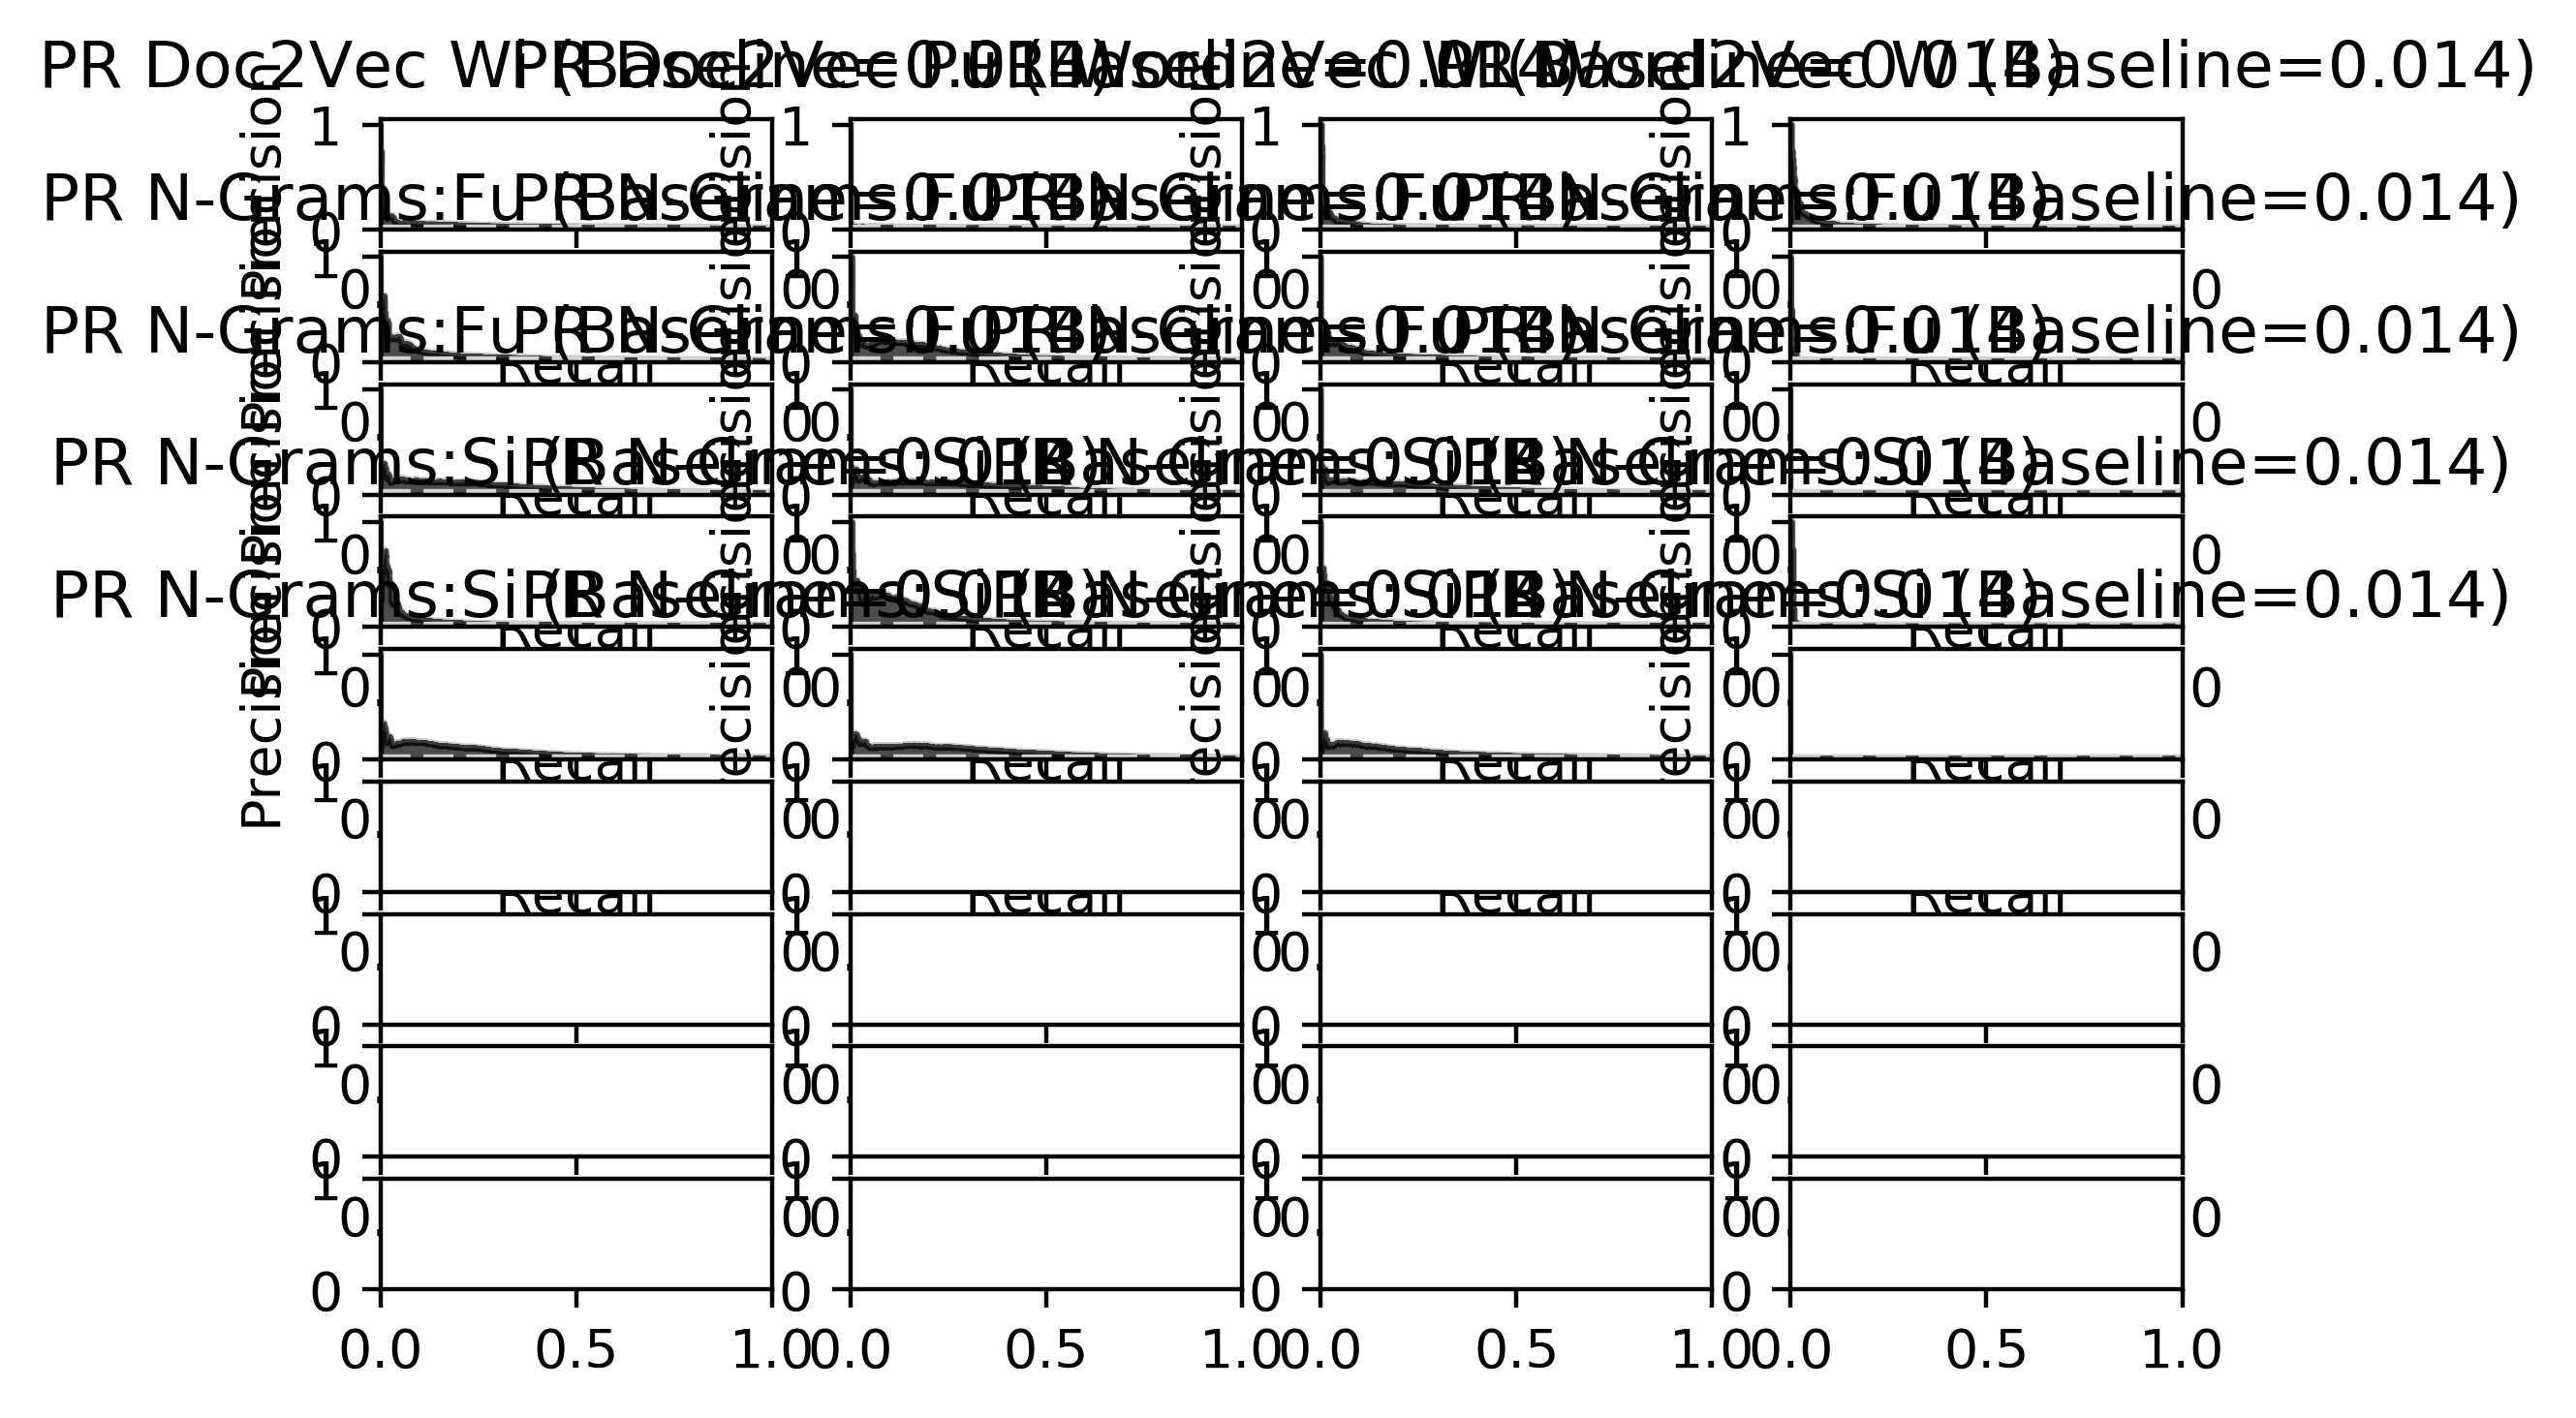

In [66]:
num_plots, plots_per_row, row_width, row_height = (len(methods), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(methods, axs.flatten()):
    
    # Obtaining the values and metrics.
    y_true = pd.DataFrame(true_dict[method]).as_matrix().flatten()
    y_prob = pd.DataFrame(pred_dict[method]).as_matrix().flatten()
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    TABLE[method].update({"mean_auc":area, "mean_baseline":baseline, "mean_ratio":auc_to_baseline_auc_ratio})

    # Producing the precision recall curve.
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.axhline(baseline, linestyle="--", color="lightgray")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("PR {0} (Baseline={1:0.3f})".format(method[:10], baseline))
    
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR,"prcurve_mean_classifier.png"),dpi=400)
plt.close()

### Predicting biochemical pathway membership based on mean similarity values
This section looks at how well the biochemical pathways that a particular gene is a member of can be predicted based on the average similarity between the vector representationt of the phenotype descriptions for that gene and each of the vector representations for other phenotypes associated with genes that belong to that particular pathway. In calculating the average similarity to other genes from a given biochemical pathway, the gene that is currently being classified is not accounted for, to avoid overestimating the performance by including information about the ground truth during classification. This leads to missing information in the case of biochemical pathways that have only one member. This can be accounted for by only limiting the overall dataset to only include genes that belong to pathways that have atleast two genes mapped to them, and only including those pathways, or by removing the missing values before calculating the performance metrics below.

### Predicting biochemical pathway or group membership with KNN classifier
This section looks at how well the group(s) or biochemical pathway(s) that a particular gene belongs to can be predicted based on a KNN classifier generated using every other gene. For this section, only the groups or pathways which contain more than one gene, and the genes mapped to those groups or pathways, are of interest. This is because for other genes, if we consider them then it will be true that that gene belongs to that group in the target vector, but the KNN classifier could never predict this because when that gene is held out, nothing could provide a vote for that group, because there are zero genes available to be members of the K nearest neighbors.

In [ ]:
"""
# Trying something new here
valid_group_ids = [group for group,id_list in group_id_to_ids.items() if len(id_list)>1]
valid_ids = [i for i in dataset.get_ids() if len(set(valid_group_ids).intersection(set(id_to_group_ids[i])))>0]

# Leave one out predictions.
pred_dict = defaultdict(lambda: defaultdict(dict))
true_dict = defaultdict(lambda: defaultdict(dict))

for method in methods[0:]:
    print(method)    
    print(vector_dicts[method][237][:20])
    print(vector_dicts[method][116][:20])
    X = [vector_dicts[method][identifier] for identifer in valid_ids]
    y = [identifier for identifier in valid_ids]
    neigh = KNeighborsClassifier(n_neighbors=4, metric="euclidean")
    neigh.fit(X,y)  
    probs = neigh.kneighbors(return_distance=True)
    for a in probs[0]:
        for b in a:
            print(float(b))
    #print(probs[0])
    print(probs[1])
    #print(len(valid_ids))
    #print(len(probs[1]))
    #print(probs[1][478])
    break
"""

In [ ]:

"""
valid_group_ids = [group for group,id_list in group_id_to_ids.items() if len(id_list)>1]
valid_ids = [i for i in dataset.get_ids() if len(set(valid_group_ids).intersection(set(id_to_group_ids[i])))>0]

# Leave one out predictions.
pred_dict = defaultdict(lambda: defaultdict(dict))
true_dict = defaultdict(lambda: defaultdict(dict))

for method in methods:
    for i in valid_ids:
        ids = [identifier for identifier in valid_ids if identifier!=i]
        # Make the labels just the ID's for that gene instead of pathways or groups, transform votes later.
        X = [vector_dicts[method][identifier] for identifier in ids]
        y = [identifier for identifier in ids]
        neigh = KNeighborsClassifier(n_neighbors=5)
        neigh.fit(X,y)
        probs = neigh.predict_proba([vector_dicts[method][i]])
        # The classes are given in lexicographic order from the predict_proba method.
        # 1. Create a 2D binary array with a row for each group and a column for each gene.
        # 2. Multiply each row of that 2D binary array with the 1D array that has the probability for each gene.
        # 3. Find the sum of each row to get the score specific to each group for this particular gene.
        # 4. Append to the arrays for the true binary classifications and the predictions for each group. 
        ids.sort()
        binary_arr = np.array([[(group_id in id_to_group_ids[x])*1 for x in ids] for group_id in valid_group_ids]) 
        group_probs_by_gene = probs*binary_arr
        group_probs = np.sum(group_probs_by_gene, axis=1)
        for group_index,group_id in enumerate(valid_group_ids):
            pred_dict[method][i][group_id] = group_probs[group_index]
            true_dict[method][i][group_id] = (i in group_id_to_ids[group_id])*1
"""

In [ ]:
"""
num_plots, plots_per_row, row_width, row_height = (len(methods), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(methods, axs.flatten()):
    
    # Obtaining the values and metrics.
    y_true = pd.DataFrame(true_dict[method]).as_matrix().flatten()
    y_prob = pd.DataFrame(pred_dict[method]).as_matrix().flatten()
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    TABLE[method].update({(TAG,"knn_auc"):area, (TAG,"knn_baseline"):baseline, (TAG,"knn_ratio"):auc_to_baseline_auc_ratio})

    # Producing the precision recall curve.
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.axhline(baseline, linestyle="--", color="lightgray")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("PR {0} (Baseline={1:0.3f})".format(method, baseline))
    
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()
fig.savefig(os.path.join(OUTPUT_DIR,"prcurve_knn_classifier.png"))
"""

<a id="output"></a>
### Summarizing the results for this notebook

In [ ]:
results = pd.DataFrame(TABLE).transpose()
columns = flatten(["Hyperparams","Topic","Data",results.columns])
results["Hyperparams"] = ""
results["Group"] = ""
results["Order"] = ""
results["Topic"] = TOPIC
results["Data"] = DATA
results = results[columns]
results.reset_index(inplace=True)
results = results.rename({"index":"Method"}, axis="columns")
hyperparam_sep = ":"
results["Hyperparams"] = results["Method"].map(lambda x: x.split(hyperparam_sep)[1] if hyperparam_sep in x else "-")
results["Method"] = results["Method"].map(lambda x: x.split(hyperparam_sep)[0])
results.to_csv(os.path.join(OUTPUT_DIR,"full_table.csv"), index=False)
results